In [1]:
from typing import Dict, Iterable, Optional

import numpy as np
import torch
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi

import pandas as pd
# torch.autograd.set_detect_anomaly(True)

Global seed set to 0


In [2]:
path = "data/datasets/A549_multiome.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.var = adata_multi.var.set_index("gene_id")

In [3]:
### test whole data with RNA only 
# path = "data/datasets/A549/A549_multiome_2.h5ad"
# path = "data/datasets/A549_multiome_2.h5ad"
# adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [7]:
adata_mvi

AnnData object with n_obs × n_vars = 3260 × 24975
    obs: 'cell_name', 'experiment', 'treatment_time', 'group', 'source', 'batch_id', 'modality'
    var: 'gene_type', 'gene_short_name', 'modality', 'feature_types', 'start', 'chr', 'end', 'peak', 'n_cells'

In [52]:
adata_mvi.var[adata_mvi.var.modality == "Peaks"]

,modality,feature_types,n_cells
gene_id,,,
1,Peaks,Peaks,389
58,Peaks,Peaks,2881
59,Peaks,Peaks,342
60,Peaks,Peaks,468
61,Peaks,Peaks,3100
...,...,...,...
189393,Peaks,Peaks,49
189399,Peaks,Peaks,57
189518,Peaks,Peaks,120


In [72]:
sc.pp.filter_cells(adata_mvi, min_counts = 600)

In [73]:
adata_mvi.X[]

AnnData object with n_obs × n_vars = 2999 × 16660
    obs: 'cell_name', 'experiment', 'treatment_time', 'batch_id', 'modality', 'n_counts'
    var: 'modality', 'feature_types', 'n_cells'

In [80]:
adata_mvi.var[adata_mvi.var.modality == "Peaks"]

,modality,feature_types,n_cells
gene_id,,,
1,Peaks,Peaks,389
58,Peaks,Peaks,2881
59,Peaks,Peaks,342
60,Peaks,Peaks,468
61,Peaks,Peaks,3100
...,...,...,...
189393,Peaks,Peaks,49
189399,Peaks,Peaks,57
189518,Peaks,Peaks,120


In [5]:
HALOVI.setup_anndata(adata_mvi, batch_key="modality", time_key='treatment_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum()
)

n_genes :14662
n_peaks:10313
fine tune is False
gate decoder initialization n_input 10, n_output 10313,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [6]:
## load pre-trained models
model = model.load("model_A549_nocausal", adata_mvi)
# model = model.load("model_A594_causal03", adata_mvi)

# model = model.load("model_hair_nocausal", adata_mvi)


INFO     File model_A549_nocausal/model.pt already downloaded                                


/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/scvi/model/base/_utils.py:145: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  warnings.warn(


ValueError: Number of vars in adata_target not the same as source. Expected: 24975 Received: 16660

In [9]:
model.module.set_finetune_params(0)
model.module.set_train_params(expr_train=True, acc_train=True)
model.train(max_epochs=1000, batch_size=512)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1000/1000: 100%|██████████| 1000/1000 [10:46<00:00,  1.55it/s, loss=5.83e+03, v_num=1]


In [6]:
# model.save("model_myeloid_data_nocausal",overwrite=True)
model.save("model_A549_nocausal",overwrite=True)

In [61]:
model.module.alpha = 0.1
model.module.beta_2 = 1e8
model.module.beta_3 = 1e8
model.module.beta_1 = 1e7
print(model.module.alpha)

0.1


In [62]:
## finetune without L0
# model.module.alpha = 0.06
model.module.set_finetune_params(2)
model.module.set_train_params(expr_train=True, acc_train=True)
model.plan_kwargs = {"n_epochs_kl_warmup":300}
model.train(max_epochs=1000, batch_size=1024)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/1000:   0%|          | 0/1000 [00:00<?, ?it/s]reconst_loss 5.81E+03, nod_loss 6.12E+06
reconst_loss 5.84E+03, nod_loss 5.68E+06
reconst_loss 5.81E+03, nod_loss 7.08E+06
Epoch 2/1000:   0%|          | 1/1000 [00:02<43:30,  2.61s/it, loss=6.3e+06, v_num=1]reconst_loss 5.87E+03, nod_loss 6.36E+06
reconst_loss 5.81E+03, nod_loss 5.62E+06
reconst_loss 5.77E+03, nod_loss 6.77E+06
Epoch 3/1000:   0%|          | 2/1000 [00:03<30:13,  1.82s/it, loss=6.28e+06, v_num=1]reconst_loss 5.78E+03, nod_loss 6.27E+06
reconst_loss 5.84E+03, nod_loss 5.96E+06
reconst_loss 5.86E+03, nod_loss 6.28E+06
Epoch 4/1000:   0%|          | 3/1000 [00:05<26:17,  1.58s/it, loss=6.24e+06, v_num=1]reconst_loss 5.81E+03, nod_loss 6.03E+06
reconst_loss 5.92E+03, nod_loss 6.48E+06
reconst_loss 5.68E+03, nod_loss 5.84E+06
Epoch 5/1000:   0%|          | 4/1000 [00:06<24:19,  1.47s/it, loss=6.21e+06, v_num=1]reconst_loss 5.76E+03, nod_loss 5.70E+06
reconst_loss 5.84E+03, nod_loss 6.28E+06
reconst_loss 5.89E+03, nod_lo

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [50]:
model.save("model_A594_causal02",overwrite=True)

In [41]:
# model = model.load("model_A594_causal01", adata_mvi)
# model = model.load("model_A549_nocausal", adata_mvi)
# model = model.load("model_A594_causal03", adata_mvi)

model = model.load("model_A594_causal015", adata_mvi)
# model = model.load("model_A594_causal005", adata_mvi)

INFO     File model_A594_causal015/model.pt already downloaded                               
n_genes :6347
fine tune is False
gate decoder initialization n_input 10, n_output 10313,         n_hidden_local 20, n_hidden_global 128, n_cat_list [1], *cat_list 1


In [10]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()

In [9]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import torch_infer_nonsta_dir

In [ ]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import torch_infer_nonsta_dir

latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score3 = []
score4=[]

cells = latent_expr.shape[0]
locals = 2000
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:,:], latent_expr_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:,:], latent_atac_indep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[i*locals:(i+1)*locals,:], latent_expr_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[i*locals:(i+1)*locals,:], latent_atac_indep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())

score3 = np.array(score3)
score4 = np.array(score4)

score3 = score3[~np.isnan(score3)]
score4 = score4[~np.isnan(score4)]
score3 = np.mean(np.array(score3))
score4 = np.mean(np.array(score4))
print("score3 {} and score4 {}".format(score3, score4))
score3 - score4

In [14]:
from complementary_models import torch_infer_nonsta_dir
from complementary_models import infer_nonsta_dir


latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')
# times = torch.tensor(times).to('cuda')
# times = np.array(times.detach().cpu())
score1 = []
score2=[]

cells = latent_expr.shape[0]
locals = 500
iterations = int(cells / locals)

for i in range(iterations):
    if i==iterations-1:
        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:,:], latent_expr_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:,:], latent_atac_dep_t[i*locals:,:], times[i*locals:])[0].detach().cpu())
    else:

        score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[i*locals:(i+1)*locals,:], latent_expr_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())
        score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[i*locals:(i+1)*locals,:], latent_atac_dep_t[i*locals:(i+1)*locals,:], times[i*locals:(i+1)*locals])[0].detach().cpu())

score1 = np.array(score1)
score2 = np.array(score2)
print("score2 : {}".format(score2))
score1 = score1[~np.isnan(score1)]
score2 = score2[~np.isnan(score2)]
score1 = np.mean(np.array(score1))
score2 = np.mean(np.array(score2))

print("score1 {} and score2 {}".format(score1, score2))


score2 : [0.0940457  0.08464843 0.07310161 0.10580706 0.10938819 0.0685983 ]
score1 0.07945549925443261 and score2 0.08926488081661217


In [43]:
latent_atac_indep_t = torch.tensor(latent_atac_indep).to('cuda')
latent_expr_indep_t = torch.tensor(latent_expr_indep).to('cuda')
times = torch.tensor(times).to('cuda')

# times = np.array(times.detach().cpu())
score3 = []
score4=[]

latent_atac_dep_t = torch.tensor(latent_atac_dep).to('cuda')
latent_expr_dep_t = torch.tensor(latent_expr_dep).to('cuda')

score1 = []
score2=[]
sample_num = 700
iterations = 30

for i in range(iterations):
    index = np.random.choice(latent_acc.shape[0] , sample_num)
    score3.append(torch_infer_nonsta_dir(latent_atac_indep_t[index,:], latent_expr_indep_t[index,:], times[index])[0].detach().cpu())
    score4.append(torch_infer_nonsta_dir(latent_expr_indep_t[index,:], latent_atac_indep_t[index,:], times[index])[0].detach().cpu())
    score1.append(torch_infer_nonsta_dir(latent_atac_dep_t[index,:], latent_expr_dep_t[index,:], times[index])[0].detach().cpu())
    score2.append(torch_infer_nonsta_dir(latent_expr_dep_t[index,:], latent_atac_dep_t[index,:], times[index])[0].detach().cpu())


score3 = np.array(score3)
score4 = np.array(score4)
# print("score3: {}".format(score3))
# print("score4: {}".format(score4))
print("score3 :{}, score4: {}, Delta :{}".format(np.mean(score3), np.mean(score4), np.mean(score3) - np.mean(score4)))

score1 = np.array(score1)
score2 = np.array(score2)

# print("score1: {}".format(score1))
# print("score2: {}".format(score2))
print("score1 :{}, score2: {}, Delta :{}".format(np.mean(score1), np.mean(score2), np.mean(score1) - np.mean(score2)))



score3 :0.07954198656206654, score4: 0.08012026256358372, Delta :-0.0005782760015171778
score1 :0.07954837953548591, score2: 0.10600473205373874, Delta :-0.026456352518252832


## nocausal results

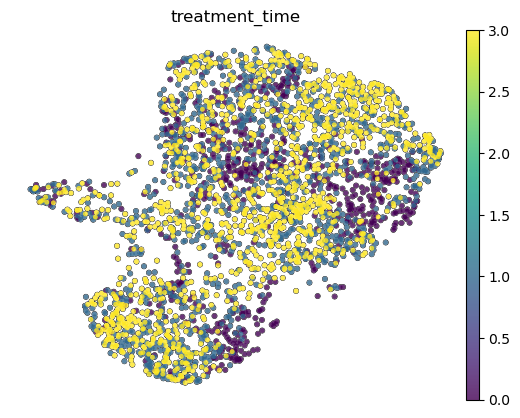

In [11]:

adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.1)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=['treatment_time'])

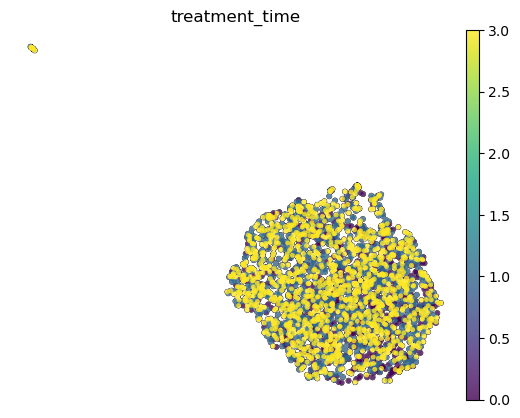

In [12]:
adata_mvi.obsm["latent"] = latent_acc
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.1)

sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["treatment_time"])

## Causal representations


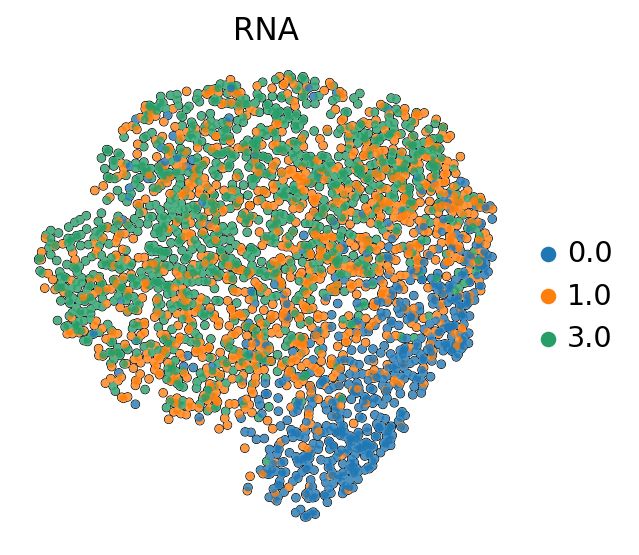

In [64]:
import seaborn as sns
adata_mvi.obsm["latent"] = latent_expr
# sc.pp.neighbors(adata_mvi, use_rep = 'latent', metric = 'manhattan')
sc.pp.neighbors(adata_mvi, use_rep = 'latent')

sc.tl.umap(adata_mvi, min_dist=0.2)

# sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=["treatment_time"], title="RNA",  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]], as_cmap=True))


sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
          outline_width=(0.1,0), color=["treatment_time"], title="RNA")

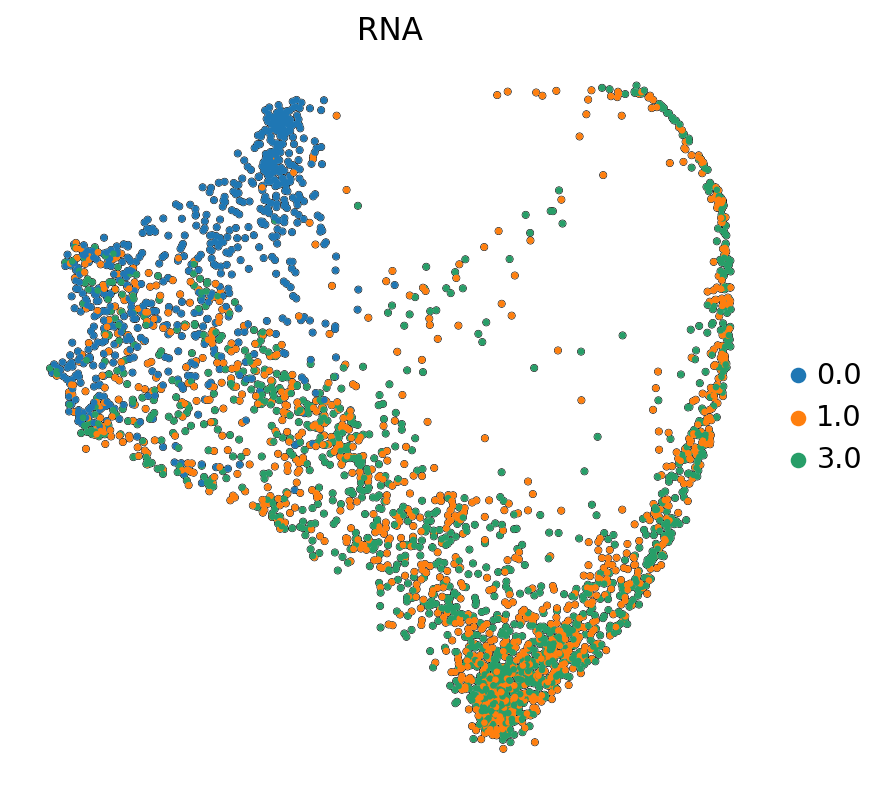

In [44]:
adata_mvi.obsm["latent"] = latent_expr
adata_mvi.obs["treatment_time"] = adata_mvi.obs["treatment_time"].astype(str)
sc.set_figure_params(figsize=(6,6))

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)

from matplotlib import pyplot as plt

# sc.set_figure_params(vector_friendly=True)
sc.pl.umap(adata_mvi, frameon=False, size = 35, alpha = 1, add_outline=True,
        outline_width=(0.1,0), color=['treatment_time'], title="RNA", color_map="PRGn")

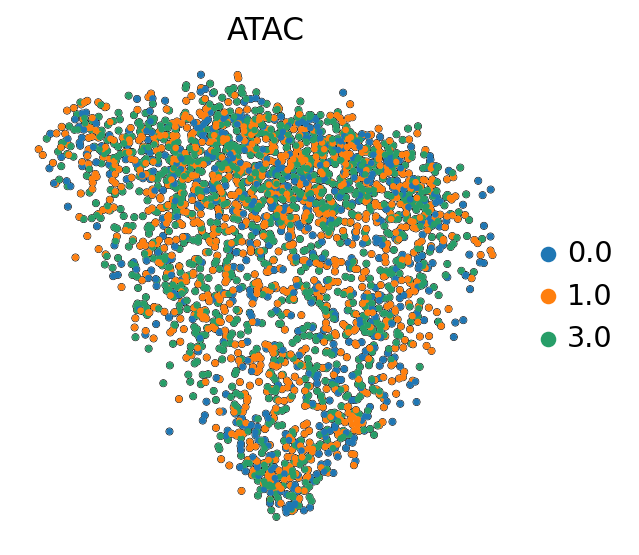

In [66]:
adata_mvi.obsm["latent"] = latent_acc
# sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15)
# sc.tl.umap(adata_mvi, min_dist=0.1)

# sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
#           outline_width=(0.05,0), color=["treatment_time"], title="ATAC")


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)
sc.set_figure_params(vector_friendly=True)
sc.pl.umap(adata_mvi, frameon=False, size = 35, alpha = 1, add_outline=True,
        outline_width=(0.1,0), color=['treatment_time'], title="ATAC", color_map="PRGn")

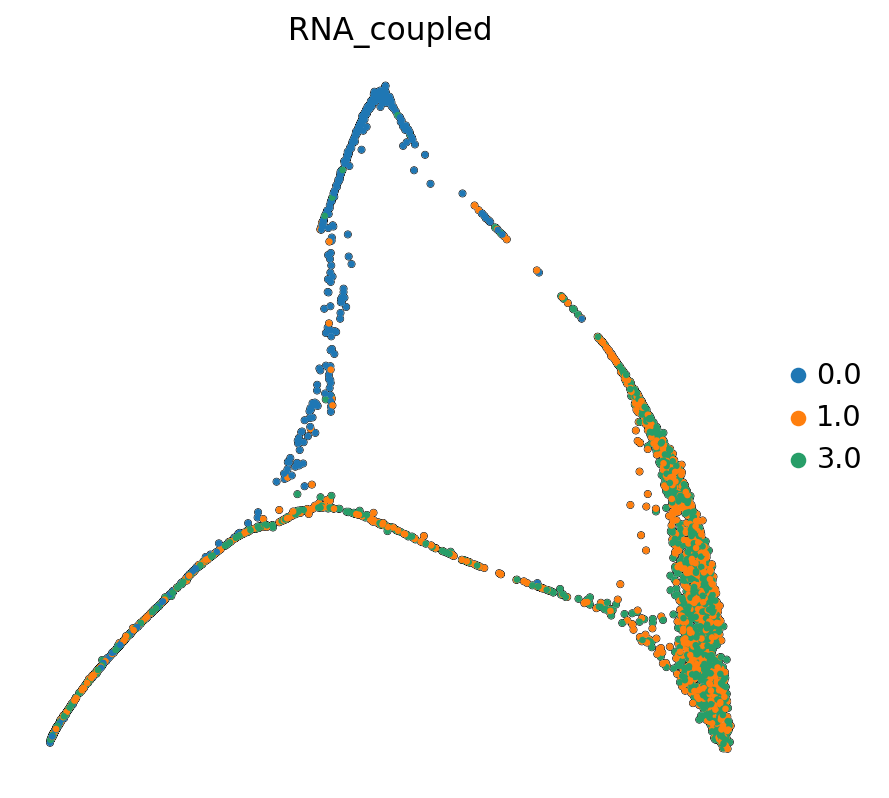

In [40]:
adata_mvi.obsm["latent"] =latent_expr_dep
# sc.pp.neighbors(adata_mvi, use_rep="latent")

# sc.tl.umap(adata_mvi,min_dist =0.5)
# %matplotlib inline
# # sc.pl.umap(adata_mvi,color=["treatment_time"], s=50, alpha = 0.8, frameon=False, ncols=2, vmax='p99', title="RNA coupled",  cmap=sns.blend_palette(["lightgray", sns.xkcd_rgb["blood"]],as_cmap=True))

# sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=["treatment_time"], title="RNA")


sc.set_figure_params(figsize=(6,6))


sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=25, metric = 'manhattan')

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.1)
# sc.set_figure_params(vector_friendly=True)
sc.pl.umap(adata_mvi, frameon=False, size = 35, alpha = 1, add_outline=True,
        outline_width=(0.1,0), color=['treatment_time'], title="RNA_coupled", color_map="PRGn")          

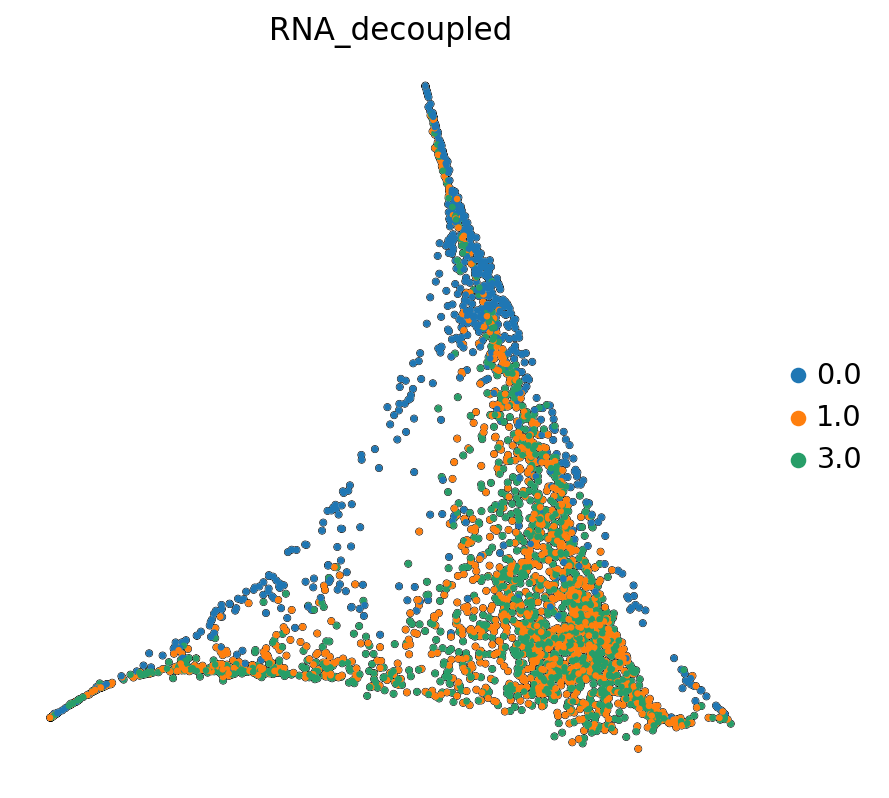

In [39]:
adata_mvi.obsm["latent"] =latent_expr_indep


sc.set_figure_params(figsize=(6,6))



# sc.pp.neighbors(adata_mvi, use_rep="latent")
# sc.tl.umap(adata_mvi,min_dist =0.1)

# %matplotlib inline
# # 
# sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 0.8, add_outline=True,
#           outline_width=(0.1,0), color=["treatment_time"], title="RNA")




sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')

sc.tl.umap(adata_mvi, min_dist=0.1, negative_sample_rate=0.05)
# sc.set_figure_params(vector_friendly=True)
sc.pl.umap(adata_mvi, frameon=False, size = 35, alpha = 1, add_outline=True,
        outline_width=(0.1,0), color=['treatment_time'], title="RNA_decoupled", color_map="PRGn")  



Epoch 106/500:  21%|██        | 105/500 [19:36<1:13:44, 11.20s/it, loss=3.27e+06, v_num=1]


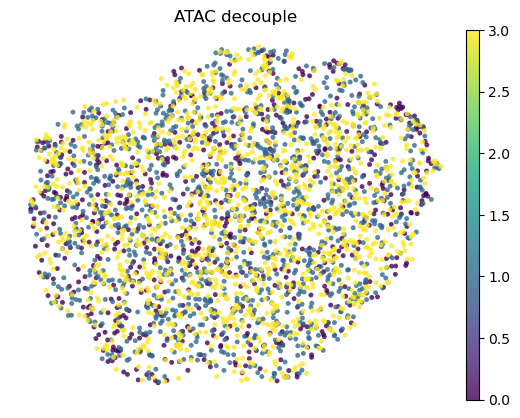

In [48]:
adata_mvi.obsm["latent"] =latent_atac_indep
sc.pp.neighbors(adata_mvi, use_rep="latent")

sc.tl.umap(adata_mvi,min_dist =0.3)

sc.pl.umap(adata_mvi,color=["treatment_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC decouple", alpha = 0.8)


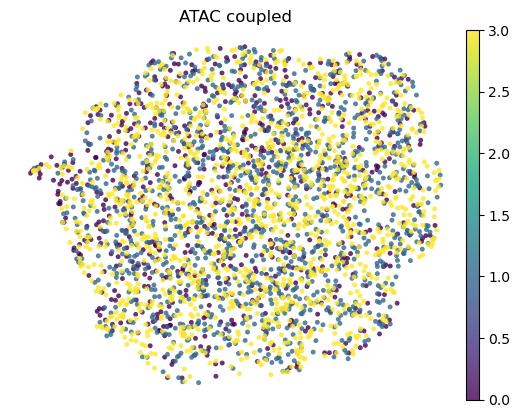

In [49]:
adata_mvi.obsm["latent"] =latent_atac_dep
sc.pp.neighbors(adata_mvi, use_rep="latent")

sc.tl.umap(adata_mvi,min_dist =0.3)

sc.pl.umap(adata_mvi,color=["treatment_time"], s=50, frameon=False, ncols=2, vmax='p99', title="ATAC coupled", alpha = 0.8)

